In [178]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import fastai
from datetime import datetime
import spacy
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.cluster import KMeans

from tqdm.auto import tqdm
from html.parser import HTMLParser
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from livelossplot import PlotLossesKeras
import re

# Keras imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from itertools import chain
import keras
import gensim.models.keyedvectors as word2vec


# Only using tokenization for now
nlp = spacy.load('en_core_web_sm', parser=False, entity=False)

tqdm.pandas()

font_size = '20.0'
dark_theme_config = {
    "ytick.color" : "w",
    "xtick.color" : "w",
    "text.color": "white",
    'font.size': font_size,
    'axes.titlesize': font_size,
    'axes.labelsize': font_size, 
    'xtick.labelsize': font_size, 
    'ytick.labelsize': font_size, 
    'legend.fontsize': font_size, 
    'figure.titlesize': font_size,
    'figure.figsize': [20, 7],
    'figure.facecolor': "#384151",
    'legend.facecolor': "#384151",
    "axes.labelcolor" : "w",
    "axes.edgecolor" : "w"
}

# TODO: Move to XAI:
def confusion_matrix(y_test, pred, label_x_neg="PREDICTED NEGATIVE", 
                     label_x_pos="PREDICTED POSITIVE", label_y_neg="ACTUAL NEGATIVE", label_y_pos="ACTUAL POSITIVE"):
    confusion = sklearn.metrics.confusion_matrix(y_test, pred)
    confusion_scaled = confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
    confusion_scaled_df = pd.DataFrame(confusion_scaled, index=[label_x_neg, label_x_pos], columns=[label_y_neg, label_y_pos])
    sns.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


sns.set(rc=dark_theme_config)
plt.rcParams.update(dark_theme_config)


In [2]:
ls data/

reddit_200k_test.csv         reddit_test.csv
reddit_200k_train.csv        reddit_train.csv
reddit_200k_train_clean.csv  rscience-popular-comment-removal.zip


In [3]:
df_cols = ["prev_idx", "body", "score", "parent_id", "id", "created_date", "retrieved_date", "removed"]

TEXT_COLUMN = "body" 
CLEAN_COLUMN = "clean_body"
TOKEN_COLUMN = "token_body"

df_200_test = pd.read_csv("data/reddit_200k_test.csv", 
                         names=df_cols, skiprows=1, encoding="ISO-8859-1")
df_200_train = pd.read_csv("data/reddit_200k_train.csv", 
                          names=df_cols, skiprows=1, encoding="ISO-8859-1")
df = pd.concat([df_200_train, df_200_test])
# We also drop the index provided as it's of no use
df = df.drop(["prev_idx", "id", "parent_id", "retrieved_date"], axis=1)
df.head()

,body,score,created_date,removed
0,I've always been taught it emerged from the ea...,2,1520121101,False
1,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,1506533157,True
2,Monday: Drug companies stock dives on good new...,5,1528087570,True
3,i learned that all hybrids are unfertile i won...,0,1504290041,False
4,Well i was wanting to get wasted tonight. Not...,3,1535140675,False


# Removing irrelevant lines
Evaluating the TFIDF feature came in handy as it clearly showed that the comments identified such as "your comment has been removed" were not discarded and made their way to the dataset, creating a lot of importance on the vectors of those words.

In [33]:
# pyarrow not working on WSL :'(
# import pyarrow
top_50.from_csv("feathers/top_50_didnt_remove.csv")

/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


,feature,tfidf
0,comment remove,0.002075
1,why be,0.001674
2,comment,0.001584
3,r,0.001467
4,many comment remove,0.001443
5,why be so,0.001348
6,remove,0.001344
7,so many comment,0.001325
8,many comment,0.001300
9,be so,0.001248


In [51]:
df = df[~df["body"].str.contains("Your submission has been removed")]
df = df[~df["body"].str.contains("This submission has been automatically removed")]

In [52]:
df = df[~df["body"].str.lower().str.contains("why are so many comments")]

# Initial insight on simple tfidf model
Before diving into more complex models, let's try a good old tfidf LR model to see initial perofrmance, and see how pre-processing of other features would allow for improvement of performance. 

In [54]:
x = df.drop("removed", axis=1)
y = df["removed"].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True)

In [55]:
class CleanTextTransformer(TransformerMixin):
    __html_parser = HTMLParser()
    __uplus_pattern = \
        re.compile("<[uU]\+(?P<digit>[a-zA-Z0-9]+)>")

    def transform(self, df_text, **kwargs):
        df_token = df_text.copy()
        df_token[CLEAN_COLUMN] = df_text[TEXT_COLUMN].progress_apply(
            CleanTextTransformer.transform_clean_text)
        return df_token

    def fit(self, X, y=None, **fit_params):
        return self
    
    @staticmethod
    def transform_clean_text(raw_text):
        try:
            decoded = raw_text.encode("ISO-8859-1").decode("utf-8")
        except:
            decoded = raw_text.encode("ISO-8859-1").decode("cp1252")
        html_unescaped = CleanTextTransformer.\
            __html_parser.unescape(decoded) 
        html_unescaped = html_unescaped.replace("\r\n", " ")
        html_unescaped = CleanTextTransformer.__uplus_pattern.sub(
            " U+\g<digit> ", html_unescaped)
        html_unescaped = html_unescaped.replace("\\", "")
        return html_unescaped

In [56]:
clean_text_transformer = CleanTextTransformer()
x_train_clean = clean_text_transformer.transform(x_train)
x_test_clean = clean_text_transformer.transform(x_test)

/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [57]:
class SpacyTokenTransformer(TransformerMixin):
    __symbols = set("!$%^&*()_+|~-=`{}[]:\";'<>?,./-")

    def transform(self, df_text, **kwargs):
        df_token = df_text.copy()
        df_token[TOKEN_COLUMN] = df_text[CLEAN_COLUMN].progress_apply(
            SpacyTokenTransformer.transform_to_token)
        return df_token

    def fit(self, X, y=None, **fit_params):
        return self
    
    @staticmethod
    def transform_to_token(text):
        doc = nlp(text, disable=['parser', 'tagger', 'ner'])
        tokens = []
        for token in doc:
            if token.like_url:
                clean_token = "URL"
            else:
                clean_token = token.lemma_.lower().strip()
                if len(clean_token) < 1 or clean_token in \
                        SpacyTokenTransformer.__symbols: 
                    continue
            tokens.append(clean_token)
        return tokens

In [58]:
spacy_tokenizer = SpacyTokenTransformer()
x_train_tokenized = spacy_tokenizer.transform(x_train_clean)
x_test_tokenized = spacy_tokenizer.transform(x_test_clean)

# Learning curve bias variance

![](images/biasvariance.png)

Hyperparam optimization to reduce overfit and improve bias

![](images/biasvariance2.png)

In [229]:
tfidf_vectorizer = TfidfVectorizer(min_df=3,  max_features=1000,
    preprocessor=lambda x: x, tokenizer=lambda x: x, token_pattern=None,
    ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)

tfidf_vectorizer.fit(x_train_tokenized[TOKEN_COLUMN].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=3,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<function <lambda> at 0x7f6ef1a7ee18>, smooth_idf=1,
        stop_words=None, strip_accents=None, sublinear_tf=1,
        token_pattern=None,
        tokenizer=<function <lambda> at 0x7f6f87c43840>, use_idf=1,
        vocabulary=None)

In [230]:
x_train_tfidf = tfidf_vectorizer.transform(
    x_train_tokenized[TOKEN_COLUMN].values)
x_test_tfidf = tfidf_vectorizer.transform(
    x_test_tokenized[TOKEN_COLUMN].values)

In [231]:
lr_model = LogisticRegression(C=1.0, verbose=True)
lr_model.fit(x_train_tfidf, y_train)

/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=True, warm_start=False)

In [232]:
pred = lr_model.predict(x_test_tfidf)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.72      0.80      0.75     13717
        True       0.60      0.49      0.54      8571

   micro avg       0.68      0.68      0.68     22288
   macro avg       0.66      0.65      0.65     22288
weighted avg       0.67      0.68      0.67     22288



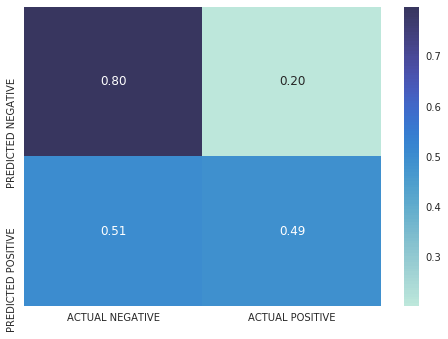

In [233]:
confusion_matrix(y_test, pred)

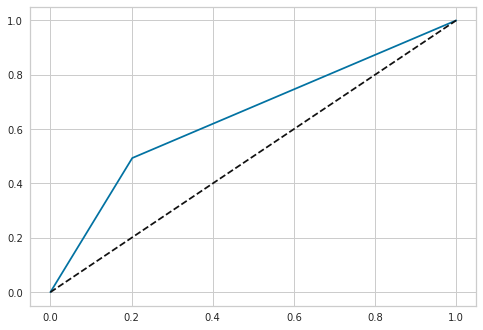

In [234]:
fpr, tpr, _ = roc_curve(y_test, pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')

In [235]:
print("AUC: ", roc_auc_score(y_test, pred))

AUC:  0.6459458619695342


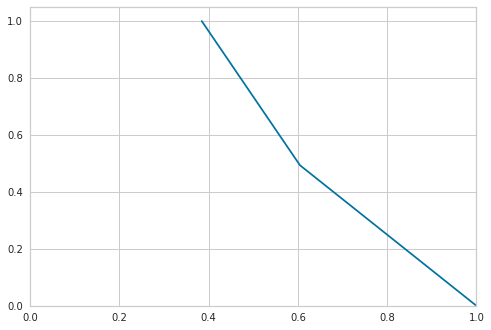

In [236]:
pr, rc, _ = precision_recall_curve(y_test, pred)
plt.plot(pr, rc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

<module 'matplotlib.pyplot' from '/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/matplotlib/pyplot.py'>

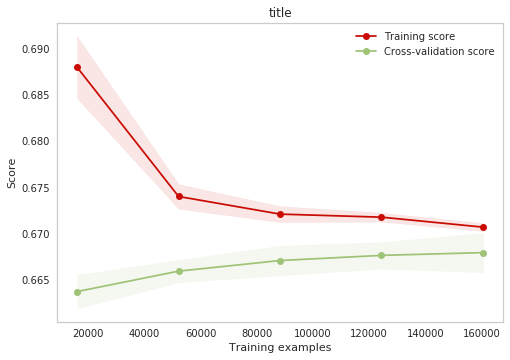

In [227]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


y_train_labels = y_train.astype(int)
plot_learning_curve(
    lr_model, 
    "title", 
    x_train_tfidf, 
    y_train_labels, 
    cv=5, n_jobs=-1)
# train_sizes, train_scores, valid_scores = learning_curve(
#         LogisticRegression(C=1.0, verbose=True), 
#         x_train_tfidf, y_train_labels, train_sizes=[50, 80, 110], cv=5)

/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", User

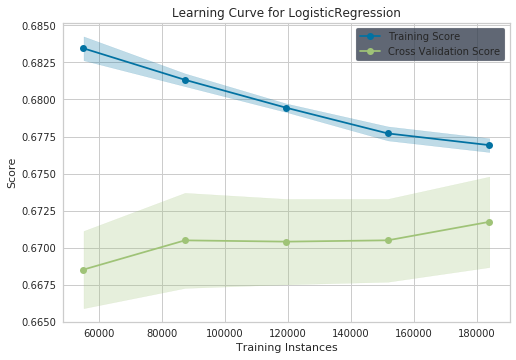

In [237]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

viz = LearningCurve(
    lr_model, cv=StratifiedKFold(12), 
    train_sizes=np.linspace(0.3, 1.0, 5),
    scoring='f1_weighted', n_jobs=12)

viz.fit(
    x_train_tfidf, 
    y_train_labels)
viz.poof()

In [ ]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Visualise correct / incorrect predictions

### Analysing the TFIDF for all the corpus for removed comments

In [172]:
top = top_mean_feats(
    x_train_tfidf[pred == True][:1000], 
    tfidf_vectorizer.get_feature_names(),
    min_tfidf=0.2,
    top_n=100)
for v in top.values: print(v, "\n\n")

['URL' 0.0014596680192035445] 


['source' 0.0012049167446464488] 


['paper URL' 0.0011632778310851403] 


[':(' 0.0011061632797067604] 


['study URL' 0.0010867374253756355] 


['incoming' 0.001] 


['URL article' 0.0009902921506230187] 


['molecular' 0.0009772149946361654] 


['motherfucker' 0.0009591184844286746] 


['link to' 0.0009550277663195839] 


['to paper URL' 0.0009425430467661374] 


['a surprise' 0.0009330580281016031] 


['that to' 0.0009126382633005292] 


['link to paper' 0.0009041764812952628] 


['to paper' 0.0008961684943039232] 


['removed' 0.0008313991968632012] 


['paper' 0.0008230606237692006] 


['hunt' 0.0008200674415315609] 


['bird be' 0.0007960072255585636] 


['tell that to' 0.0007870096891975947] 


['be not this' 0.0007700331694525935] 


['everybody' 0.0007694751161123195] 


['finally' 0.0007614652845457291] 


['russia' 0.0007464883281128685] 


['-pron- have call' 0.0007450317037423828] 


['koala' 0.0007412716955369049] 


['have call' 0.000725

In [176]:
df[df["body"].str.contains(":(", regex=False)]["removed"].value_counts()

False    201
True     189
Name: removed, dtype: int64

### False Positives

In [159]:
for v in x_test[(y_test == False) & (pred == True)]["body"].values: print(v, "\n\n")

Ironically, I post more on social media when I am bored than when I am out with my friends. What does this say about me? 


And yet we still eat them.  


Unless a large proportion forgot they smoked po. 


Very sad. Everything is going and we're to blame.  


Started smoking when I was 15. Nailed it 


Apple won't do it. Ruins their whole slimy business model. 


I'm sure the study wasn't politically motivated at all. 


Not me. I'm great. 

I'm great. 

I'm. Great.  


Nobody exists on purpose, nobody belongs anywhere, everybody's going to die. Come watch TV.Â 

 


When I get a glass of drinking water from the filter in my fridge (which I change as directed) it tastes fine if I drink it right away. If I let it sit out for a few hours and then drink it, it tastes like aspirin or some chemical.  Why? 


Nice try, eugenecists. 


Ive never smoked too much and called my ex or crashed my car, it's pretty obvious  


This makes me so very mad.  I love eating seafood.  I don't because of a

I hate life also and I'm 22 gonna be 23 in like 10 days and this has been the worst year of my life. My mom lost her job because she has cirrhosis of the liver (she doesn't even drink) and we lost our house due to foreclosure, I put my education on hold to help my ungrateful cousin by watching her 3 children well she goes to work and does god knows what for 12 hours. Now my mom is losing her car and I can't get to a job or start school ( I owe like 250$ for a class I didn't even take) and life just seems like it's going to shit. My mom will know next month if she will get disability since she can't work, I hope that she gets it cause if not life is gonna get even worse.  My mom also has severe depression which I fear every day I'm gonna find her dead due to suicide so I have to pretend I'm happy everyday to not make her more depressed and it is eating away at me mentally. 

Honestly I would gladly welcome a apocalypse type of event just so this shit ends.  


Im confused, why are all t

We never tried injecting immune stimulating agents directly into the tumor before?   Wtf scientists!   


Why is this even a debate anymore?? 


Yes we will all have symbiotes 


Not a single un mod-removed comment in this entire 4.5k post. Embarrassing. Why not just make this entire sub read-only  


Please cure tinnitus. Please cure tinnitus. Please cure tinnitus.  


The difference between AIDS and OPIOIDS is, only Big Pharma can make $Bs off AIDS, but every...hey, wait a minute! 


cool, now make flushable wet wipes please 


Then it's still a heterotroph; so, it's nothing like a plant. 


Man, this subreddit might as well shut down, the alt-right take over in here is just about complete. 


Yeah and it's even worse. 


This was a great show and in my opinion raised way more awareness than any harm it caused.  


Shut the fuck up Brodsky and Amabile before management hears you. 


Cults perform the same function, with much the same results.

Organized religion has set us back 1000 

In [162]:
top_mean_feats(
    x_train_tfidf[(y_test == False) & (pred == True)][:1000], 
    tfidf_vectorizer.get_feature_names(),
    min_tfidf=0.2,
    top_n=50)

,feature,tfidf
0,URL,0.001739
1,oil,0.001160
2,america,0.000953
3,oil company,0.000934
4,do not read,0.000932
5,that to,0.000913
6,paper URL,0.000888
7,not read,0.000850
8,:(,0.000844
9,removed,0.000831


### False Negatives

In [168]:
# U+1F44F = 👏👏👏👏
df[df["body"].str.contains("1F44F")]

,body,score,created_date,removed
33043,YAS YAS YAS <U+0001F44F><U+0001F44F><U+0001F44...,2,1510319841,True
33901,<U+0001F44F><U+0001F3FC>science<U+0001F44F><U+...,6,1509148307,True
80420,Trump: No it will not. Coal is the greatest fu...,0,1496440932,True
97242,Congrats you prevented Alzheimer's disease.......,2,1517680720,True
108729,The <U+0001F44F>Earth<U+0001F44F>is<U+0001F44F...,-53,1506637191,True
145537,Butbutbut... gender <U+0001F44F> is <U+0001F44...,2,1518060803,True
166084,Didn't you hear? Its not real. <U+0001F44F>,0,1485454977,True


In [161]:
for v in x_test[(y_test == True) & (pred == False)]["body"].values: print(v, "\n\n")

With how much I pay in insurance, I cant afford to buy ramen noodles, much less cigarettes. 


Talk about objectifying... 


So, if  a man father's a child but does not know it, does he gain weight?  The fact that most men gain weight as they enter their 40's (30's?) means they have kids? I fail to see any biological reason for a father to change cause he got laid. For all I know, I have boatloads of kids. Seriously, do they mean males who raise children? I can see physiological  and hormonal changes occuring then. Seems like the article is kinda b.s. 


Why should this be any surprise?

In any one of the average months of the last 30 years of my life I've probably ingested more alcohol and drugs than my dad has in his entire 90 years.

We eat more fat, salt, sugar and processed foods than any generation before us.

Our life expectancy is going up because of progress in medial care, not because we're taking more care of ourselves. 


This is really interesting technology.  My only con

We need to start testing ANTIFA for this, obviously is a case of "body searchers". 


When your prescribed abstinence period is shorter than your refractory period... 


Read about this long ago. In more reliable subs.  


Typical British style. Named the animal after pub landlord..

http://www.telegraph.co.uk/science/2017/11/07/mankinds-oldest-mammal-ancestor-discovered-west-country-rat/ 


I know for a fact after the San Bernardino shooting that the waiting list for a CC went through the roof. I think this study is probably skewed  


There is no new news here.  There may be an awakening of the oppressive and corrosive effect of the medical-pharmaceutical complex that has suppressed this long known knowledge for literally decades. 


How stupid do you have to be to fall for this? 
Shitpost. 


Link is broken! Cover up!  


I'm confused because no one else seems to be commenting on my issue, but 5kg is a LOT of broccoli. Like more than 10 POUNDS of broccoli. That's a pretty misleading

This is where a lot of Americans stop reading. Y'aint takin mah beef! 


Rodents of unusually large size? 


These results carry over to anyone who undergoes and consistently holds to a new exercise routine.  I dont believe its specific to yoga 


Thank you for posting this to help combat stigma and misunderstanding. It's much more helpful to understand that it releases neurotransmitters to reduce pain. Physical and emotional pain can be reduced by the same pathways, I believe. I don't recommend it as a coping mechanism because once you start it can be hard to stop, it's best to work on finding less harmful coping mechanisms. Some who do self harm find temporary alternatives to break the urges such as holding ice in their hands or on their wrists. It's better to practice ways to regulate and reduce emotions, use mindfulness, etc. It is possible to cope with pain, frustration, anger, emotion in better ways.

As the article mentioned some have found DBT can make a significant difference,

Great! Note to self: double your small caliber ammo orders for self defense. 


Meaning man are generally has healthier brains than woman.   


Science is never settled.  That's what Nye doesn't understand.  In the 70's there was a consensus the world was headed for another ice age.  Hypotheses change, and the model needs to be reworked if predictions do not hold true. 


95k in SoCal is making ends meet 


But what's the read speed? 


No reward in working hard. I'm still working on my degree but in past year I have changed like 3 jobs and managed to increase my pay rate by almost double. And half the hours.  


it's not about people being "dumb" that they don't accept climate change as fact, it's that oil and gas companies legally bribe officials into laxing regulation. nothing will be done about it until money is gotten out of politics, which seems highly unlikely 


Stand by for Neil Degrasse Tyson to make some pedantic tweet if anyone dares to get excited about science.  


Joinin

Well that explains it  


Everyone should be able to take naps after lunch. 


I'm genuinely asking about this - could this have been caused by "grass fed" or "ethically raised" cattle?  


Sounds like no method works and its more or less ineffective. 


It's because everyone is comfortable with anticipating the actions of other people. We're all pretty good at it. You can see warning signs.

People with mental illnesses are unknown quantities. Your average person can't predict how they will act.

That's an uncomfortable feeling for people. 


i'll bet that evolution does not care if your teeth make it to 40 as long as you pop out kids early on.  


Pretty much the same strategy as the tobacco lobby: withhold the information you do have, while sowing misinformation and doubt in the public media.  


Is Jenny McCarthy laundering rubles, too? 


Higher temps and higher CO2 concentration is how dinosaurs and flora in the past grew so large.  Even professional marijuana growers pump CO2 in

In [163]:
top_mean_feats(
    x_train_tfidf[(y_test == True) & (pred == False)][:1000], 
    tfidf_vectorizer.get_feature_names(),
    min_tfidf=0.2,
    top_n=50)

,feature,tfidf
0,URL,0.001482
1,sounds like,0.001087
2,paper URL,0.001068
3,paper,0.000992
4,resveratrol,0.000982
5,u+0001f44f,0.000907
6,paging,0.000884
7,incredibly,0.000872
8,#,0.000868
9,sounds,0.000835


In [71]:
small_test = tfidf_vectorizer.transform([ [ "you", "are", "an", "idiot" ] ])
lr_model.predict(small_test)

array([False])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


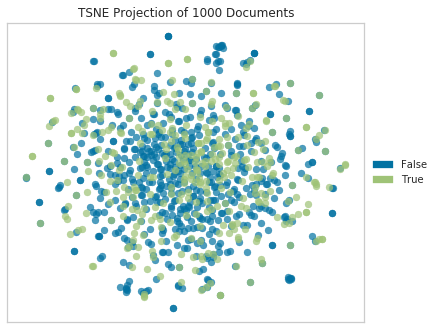

In [48]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize the text
n_visualise = 1000

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(x_train_tfidf[:n_visualise], y_train[:n_visualise])
tsne.poof()


In [49]:

clusters = KMeans(n_clusters=5)
%time clusters.fit(x_train_tfidf[:n_visualise])

CPU times: user 20.4 s, sys: 688 ms, total: 21.1 s
Wall time: 3.55 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

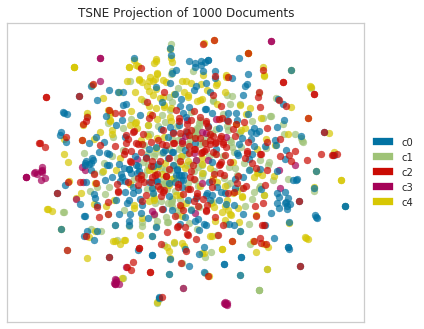

In [50]:
tsne = TSNEVisualizer()
tsne.fit(x_train_tfidf[:n_visualise], 
         ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

In [51]:
df[:n_visualise][clusters.labels_==2]

,body,score,created_date,removed
5,So when we can remember a history where he sha...,4,1494006743,False
9,"Hi BocceBaller42, your post has been removed f...",2,1485793932,False
10,Kinda what happens when people think morality ...,8,1522760848,False
13,If medicine keeps advancing the rate as it is ...,3,1494371185,False
22,See thoughts and prayers help others by loweri...,5,1508000676,False
30,&gt;âThe results reveal that having a physic...,4,1500091471,False
39,The flaw I see in the study is the focus on ra...,0,1529334765,True
40,My Strong app has made a huge difference for m...,2,1526126637,False
41,I dont believe this shit for one moment. Can ...,-9,1514509258,True
49,How did you choose your subfield? Number theor...,2,1520006350,False


# We'll try a deep neural network

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train_tokenized[TOKEN_COLUMN].values)

X_train = tokenizer.texts_to_sequences(x_train_tokenized[TOKEN_COLUMN].values)
X_test = tokenizer.texts_to_sequences(x_test_tokenized[TOKEN_COLUMN].values)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

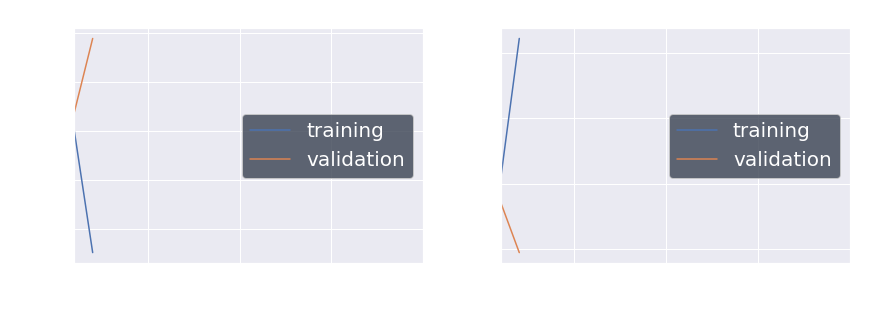

Log-loss (cost function):
training   (min:    0.488, max:    0.550, cur:    0.488)
validation (min:    0.559, max:    0.597, cur:    0.597)

Accuracy:
training   (min:    0.702, max:    0.744, cur:    0.744)
validation (min:    0.679, max:    0.694, cur:    0.679)
Epoch 3/20
  8990/201034 [>.............................] - ETA: 17:08 - loss: 0.3866 - acc: 0.8073

KeyboardInterrupt: 

In [23]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[PlotLossesKeras()])

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("models/keras-model-initial.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/keras-model-initial.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8150
Testing Accuracy:  0.6686


In [11]:
w2v = word2vec.KeyedVectors.load_word2vec_format(
    "models/GoogleNews-vectors-negative300.bin", 
    binary=True)
vocab = w2v.wv.vocab

/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [61]:
NUM_WORDS = 5000
tokenizer = Tokenizer(num_words=NUM_WORDS)
# tokenizer.fit_on_texts(x_train_tokenized[TOKEN_COLUMN].values)
all_words = list(chain(*x_train_tokenized[TOKEN_COLUMN]))
tokenizer.fit_on_texts(all_words)
# vocab_size = len(all_words) + 1
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

X_train = tokenizer.texts_to_sequences(x_train_tokenized[TOKEN_COLUMN].values)
X_test = tokenizer.texts_to_sequences(x_test_tokenized[TOKEN_COLUMN].values)

# This number was decided based on the distribution of lengths of text
maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
embedding_matrix = np.zeros((vocab_size, w2v.vector_size))
not_found = []
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = w2v[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        not_found.append(word)
        embedding_matrix[i] = np.random.normal(
            0, np.sqrt(0.25), w2v.vector_size)
        
print("Number of words not available: ", len(not_found))

Number of words not available:  55658


In [22]:
def convert_and_extend_date(df, field_name, drop=True):
    field = df[field_name].progress_apply(datetime.fromtimestamp)
    attr = ['month', 'week', 'day', 'dayofweek', 'dayofyear',
            'is_month_end', 'is_month_start', 'is_quarter_end', 
            'is_quarter_start', 'is_year_end', 'is_year_start',
            'hour', 'minute', 'second']
    for n in attr: df[field_name + "_" + n] = getattr(field.dt, n.lower())
    if drop: df.drop(field_name, axis=1, inplace=True)

X_train_extended = x_train.copy()
X_test_extended = x_test.copy()
convert_and_extend_date(X_train_extended, "created_date")
convert_and_extend_date(X_test_extended, "created_date")

In [17]:
input_layers = []
encoded_layers = []

embedding_layer = Embedding(
    input_dim=vocab_size, 
    output_dim=w2v.vector_size, 
    weights=[embedding_matrix], 
    input_length=maxlen, 
    trainable=False)

input_for_embedding = Input(shape=(maxlen,))
input_layers.append(input_for_embedding)
encoded_layers.append(
    Flatten()(embedding_layer(input_for_embedding)))

input_for_size = Input(shape=(1,))
input_layers.append(input_for_size)
encoded_layers.append(input_for_size)

for col in X_train_extended.columns:
    if not "created" in col: 
        continue
    input_layer = Input(shape=(1,))
    input_layers.append(input_layer)
    embedding_layer = Flatten()(
        Embedding(X_train_extended[col].max()+1, 1)(input_layer))
    encoded_layers.append(embedding_layer)

concat_encoded_layers = concatenate(encoded_layers)
core_layers = Dropout(0.5)(
    Dense(20, activation="relu")(concat_encoded_layers))
output_layer = Dense(1, activation='sigmoid')(core_layers)

# train model
model = Model(inputs=input_layers, outputs=[output_layer])
model.compile(
    optimizer="adam", 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer) 

In [77]:
X_train_extended = X_train_extended.drop("body", axis=1)
X_test_extended = X_test_extended.drop("body", axis=1)

X_train_extended_input = [X_train] + [X_train_extended[col].values for col in X_train_extended.columns]
X_test_extended_input = [X_test] + [X_test_extended[col].values for col in X_test_extended.columns]

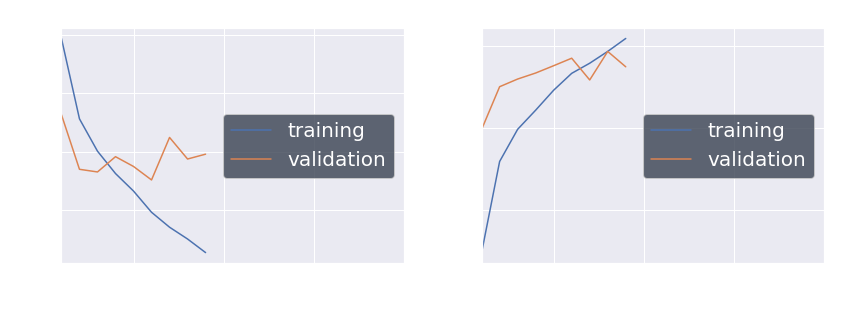

Log-loss (cost function):
training   (min:    0.545, max:    0.619, cur:    0.545)
validation (min:    0.570, max:    0.593, cur:    0.579)

Accuracy:
training   (min:    0.649, max:    0.702, cur:    0.702)
validation (min:    0.680, max:    0.699, cur:    0.695)
Epoch 10/20
 18930/201034 [=>............................] - ETA: 4:27 - loss: 0.5397 - acc: 0.7005

KeyboardInterrupt: 

In [84]:
history = model.fit(X_train_extended_input, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test_extended_input, y_test),
                    batch_size=10,
                    callbacks=[PlotLossesKeras()])

In [85]:
# serialize model to JSON
model_json = model.to_json()
with open("models/keras-model-w2v-extended.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/keras-model-w2v-extended.h5")
print("Saved model to disk")

Saved model to disk


In [86]:
loss, accuracy = model.evaluate(X_train_extended_input, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_extended_input, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7337
Testing Accuracy:  0.6949


In [89]:
probabilities = model.predict(X_test_extended_input, verbose=False)

In [103]:
pred = probabilities> 0.5

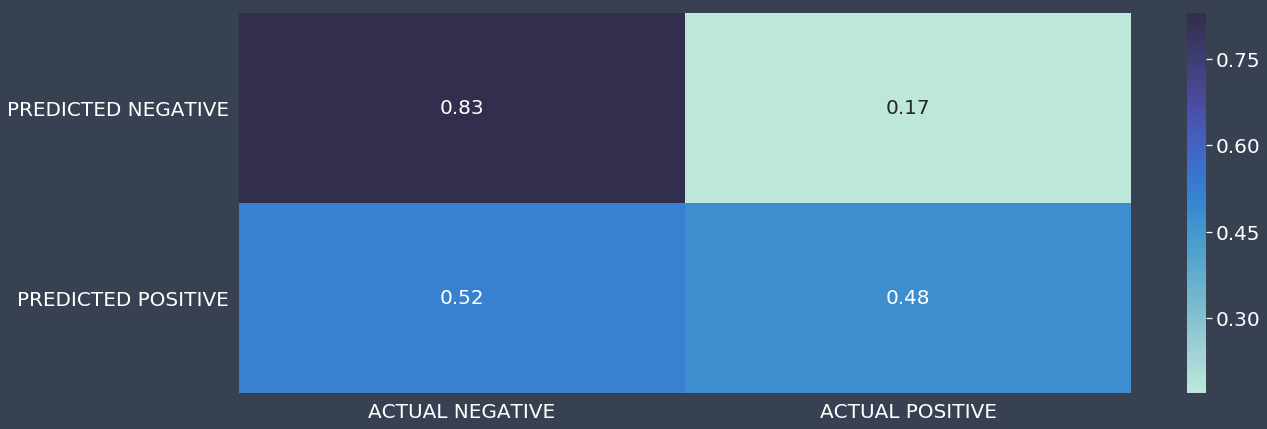

In [108]:
confusion_matrix(y_test, pred)

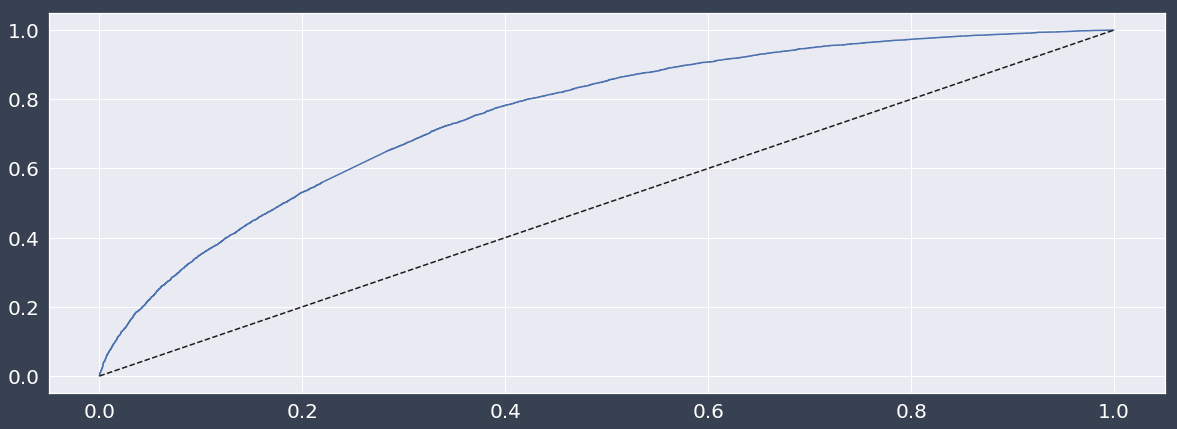

In [100]:
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')

![image.png](https://i.ytimg.com/vi/jLLfBDJEB_g/maxresdefault.jpg)

In [ ]:
# from sklearn.base import BaseEstimator, ClassifierMixin

# class KerasW2VClassifier():
#     def __init__(self):
#         self.__model = self.__initialize_keras_model()
        
#     def __initialize_keras_model(self):
#         input_layers = []
#         encoded_layers = []

#         embedding_layer = Embedding(
#             input_dim=vocab_size, 
#             output_dim=w2v.vector_size, 
#             weights=[embedding_matrix], 
#             input_length=maxlen, 
#             trainable=False)

#         input_for_embedding = Input(shape=(maxlen,))
#         input_layers.append(input_for_embedding)
#         encoded_layers.append(
#             Flatten()(embedding_layer(input_for_embedding)))

#         input_for_size = Input(shape=(1,))
#         input_layers.append(input_for_size)
#         encoded_layers.append(input_for_size)

#         for col in X_train_extended.columns:
#             if not "created" in col: 
#                 continue
#             input_layer = Input(shape=(1,))
#             input_layers.append(input_layer)
#             embedding_layer = Flatten()(
#                 Embedding(X_train_extended[col].max()+1, 1)(input_layer))
#             encoded_layers.append(embedding_layer)

#         concat_encoded_layers = concatenate(encoded_layers)
#         core_layers = Dropout(0.5)(
#             Dense(20, activation="relu")(concat_encoded_layers))
#         output_layer = Dense(1, activation='sigmoid')(core_layers)

#         # train model
#         model = Model(inputs=input_layers, outputs=[output_layer])
#         model.compile(
#             optimizer="adam", 
#             loss='binary_crossentropy', 
#             metrics=['accuracy'])

#         model.summary()


In [106]:
# Creating bert data
x_train_bert = x_train_tokenized.copy()
x_test_bert = x_test_tokenized.copy()

In [110]:
x_train_bert_dropped = x_train_bert.drop(["created_date", "clean_body", "score", "body"], axis=1)
x_test_bert_dropped = x_test_bert.drop(["created_date", "clean_body", "score", "body"], axis=1)

In [111]:
x_train_bert_dropped["removed"] = y_train
x_test_bert_dropped["removed"] = y_test

In [113]:
x_train_bert_dropped["token_body"] = x_train_bert_dropped["token_body"].progress_apply(lambda x: " ".join(x))
x_test_bert_dropped["token_body"] = x_test_bert_dropped["token_body"].progress_apply(lambda x: " ".join(x))

In [120]:
x_train_bert_dropped["a"] = ["a"]*x_train_bert_dropped.shape[0]
x_test_bert_dropped["a"] = ["a"]*x_test_bert_dropped.shape[0]

In [128]:
x_train_bert_dropped = x_train_bert_dropped.reindex([ "removed", "a", "token_body"], axis=1)
x_test_bert_dropped = x_test_bert_dropped.reindex([ "removed", "a", "token_body"], axis=1)

In [133]:
x_train_bert_dropped = x_train_bert_dropped.reset_index().drop(["index"],axis=1)
x_test_bert_dropped = x_test_bert_dropped.reset_index().drop(["index"],axis=1)

In [140]:
x_train_bert_dropped["removed"] = x_train_bert_dropped["removed"].progress_apply(lambda x: 1 if x else 0)
x_test_bert_dropped["removed"] = x_test_bert_dropped["removed"].progress_apply(lambda x: 1 if x else 0)

In [141]:
x_train_bert_dropped.reset_index().to_csv("bert/data/train.tsv",sep='\t', index=False, header=False)
x_test_bert_dropped.reset_index().to_csv("bert/data/dev.tsv",sep='\t', index=False, header=False)

In [142]:
!python bert/run_classifier.py \
    --task_name=cola \
    --do_train=true \
    --do_eval=true \
    --data_dir=./bert/data \
    --vocab_file=./bert/model/vocab.txt \
    --bert_config_file=./bert/model/bert_config.json \
    --init_checkpoint=./bert/model/bert_model.ckpt \
    --max_seq_length=128 \
    --train_batch_size=32 \
    --learning_rate=2e-5 \
    --num_train_epochs=3.0 \
    --output_dir=.bert/bert_output/


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': '.bert/bert_output/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbda3cdb320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Writing example 90000 of 200583
INFO:tensorflow:Writing example 100000 of 200583
INFO:tensorflow:Writing example 110000 of 200583
INFO:tensorflow:Writing example 120000 of 200583
INFO:tensorflow:Writing example 130000 of 200583
INFO:tensorflow:Writing example 140000 of 200583
INFO:tensorflow:Writing example 150000 of 200583
INFO:tensorflow:Writing example 160000 of 200583
INFO:tensorflow:Writing example 170000 of 200583
INFO:tensorflow:Writing example 180000 of 200583
INFO:tensorflow:Writing example 190000 of 200583
INFO:tensorflow:Writing example 200000 of 200583
INFO:tensorflow:***** Running training *****
INFO:tensorflow:  Num examples = 200583
INFO:tensorflow:  Batch size = 32
INFO:tensorflow:  Num steps = 18804
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running train 

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
2019-04-15 18:13:11.305243: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-04-15 18:13:11.336079: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
2019-04-15 18:13:11.339662: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x7fbd7859e110 executing computations on platform Host. Devices:
2019-04-15 18:13:11.339708: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #213: KMP_AFFINITY: x2APIC ids not unique - decoding legacy APIC ids.
OMP: Info #232: KMP_AFFINITY: legacy APIC ids not unique - parsing /proc/cpuinfo.
OMP: Info #148: KMP_AFFINITY: Affinity capable, using cpuinfo file
OMP: I